In [1]:
import numpy as np

# Importing standard Qiskit libraries
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister, transpile, Aer, IBMQ, execute
from qiskit.circuit import Parameter
from qiskit.tools.jupyter import *
from qiskit.visualization import *
#from ibm_quantum_widgets import *
from qiskit.providers.aer import QasmSimulator
from qiskit.circuit.library.standard_gates import RYGate

from qiskit.visualization import plot_histogram

# Loading your IBM Quantum account(s)
provider = IBMQ.load_account()

In [2]:
n_qubits = 9
qc = QuantumCircuit(n_qubits)

In [3]:
l = 2 
qc.cnot(7,8)
qc.cry(2*np.arccos(np.sqrt(1/l)),8,7)
qc.cnot(7,8)

qc.cnot(6,8)
CCRY=RYGate(2*np.arccos(np.sqrt(2/l))).control(2)
qc.append(CCRY,(8,7,6))
qc.cnot(6,8)

qc.draw()

q_0: ────────────────────────────────────────
                                             
q_1: ────────────────────────────────────────
                                             
q_2: ────────────────────────────────────────
                                             
q_3: ────────────────────────────────────────
                                             
q_4: ────────────────────────────────────────
                                             
q_5: ────────────────────────────────────────
                               ┌───────┐     
q_6: ───────────────────────■──┤ Ry(0) ├──■──
          ┌─────────┐       │  └───┬───┘  │  
q_7: ──■──┤ Ry(π/2) ├──■────┼──────■──────┼──
     ┌─┴─┐└────┬────┘┌─┴─┐┌─┴─┐    │    ┌─┴─┐
q_8: ┤ X ├─────■─────┤ X ├┤ X ├────■────┤ X ├
     └───┘           └───┘└───┘         └───┘

In [4]:
def SCS(n,l):
    qc = QuantumCircuit(n)

    qc.cnot(l-2,l-1)
    qc.cry(2*np.arccos(np.sqrt(1/l)),l-1,l-2)
    qc.cnot(l-2,l-1)

    for i in range(l-1,1,-1):
        qc.cnot(i-2,l-1)
        #print((l-i+1)/l)
        CCRY=RYGate(2*np.arccos(np.sqrt((l-i+1)/l))).control(2)
        qc.append(CCRY,(l-1,i-1,i-2))
        qc.cnot(i-2,l-1)
    
    return(qc)


In [5]:
n = 4

U99 = QuantumCircuit(n)

for l in range(n,1,-1):
    sc = SCS(n,l)
    U99 = U99 + sc

U99.draw()

/home/alb/Scrivania/Quantum/Projects/Applications/QAOA-CellFreeMIMO/virtual_QAOA-CellFreeMIMO/lib/python3.7/site-packages/ipykernel_launcher.py:7: DeprecationWarning: The QuantumCircuit.__add__() method is being deprecated.Use the compose() method which is more flexible w.r.t circuit register compatibility.
  import sys


┌─────────┐          »
q_0: ─────────────────────────────────────────────■──┤ Ry(π/3) ├──■───────»
                                ┌─────────┐       │  └────┬────┘  │       »
q_1: ────────────────────────■──┤ Ry(π/2) ├──■────┼───────■───────┼────■──»
          ┌──────────┐       │  └────┬────┘  │    │       │       │  ┌─┴─┐»
q_2: ──■──┤ Ry(2π/3) ├──■────┼───────■───────┼────┼───────┼───────┼──┤ X ├»
     ┌─┴─┐└────┬─────┘┌─┴─┐┌─┴─┐     │     ┌─┴─┐┌─┴─┐     │     ┌─┴─┐└───┘»
q_3: ┤ X ├─────■──────┤ X ├┤ X ├─────■─────┤ X ├┤ X ├─────■─────┤ X ├─────»
     └───┘            └───┘└───┘           └───┘└───┘           └───┘     »
«                             ┌───────────┐          ┌─────────┐     
«q_0: ─────────────────────■──┤ Ry(1.231) ├──■────■──┤ Ry(π/2) ├──■──
«     ┌────────────┐       │  └─────┬─────┘  │  ┌─┴─┐└────┬────┘┌─┴─┐
«q_1: ┤ Ry(1.9106) ├──■────┼────────■────────┼──┤ X ├─────■─────┤ X ├
«     └─────┬──────┘┌─┴─┐┌─┴─┐      │      ┌─┴─┐└───┘           └───┘
«q_2: ──────■───────┤ X ├┤ X ├──────■──────┤ X ├─────────────────────
«                   └───┘└───┘             └───┘                     
«q_3: ───────────────────────────────────────────────────────────────
«

In [6]:
start_state_circ = QuantumCircuit(n)
k = 3
for i in range(n-1,n-k-1,-1):
    start_state_circ.x(i)

start_state_circ.draw()  

q_0: ─────
     ┌───┐
q_1: ┤ X ├
     ├───┤
q_2: ┤ X ├
     ├───┤
q_3: ┤ X ├
     └───┘

/home/alb/Scrivania/Quantum/Projects/Applications/QAOA-CellFreeMIMO/virtual_QAOA-CellFreeMIMO/lib/python3.7/site-packages/ipykernel_launcher.py:4: DeprecationWarning: The QuantumCircuit.__add__() method is being deprecated.Use the compose() method which is more flexible w.r.t circuit register compatibility.
  after removing the cwd from sys.path.


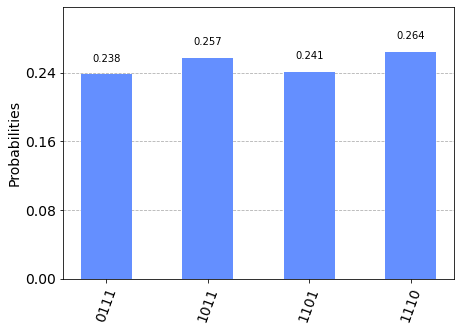

In [7]:
backend = Aer.get_backend('aer_simulator')
backend.shots = 1024

qc = start_state_circ + U99 
qc.measure_all()

qc = transpile(qc, backend)

counts = backend.run(qc, seed_simulator=2701, nshots=4).result().get_counts()
plot_histogram(counts)

In [8]:
print(2*np.arccos(np.sqrt( 1/4 )))
print(2*np.arccos(np.sqrt( 2/4 )))
print(2*np.arccos(np.sqrt( 3/4 )))
print('----')
print(2*3.14/3)
print(3.14/2)

2.0943951023931957
1.5707963267948966
1.0471975511965979
----
2.0933333333333333
1.57


In [9]:
from src import QAOA_utilities as QAOAut

In [12]:
n = 9
U99 = QAOAut.Unn(n)
U99.draw()

»
q_0: ────────────────────────────────────────────────────────────────────────»
                                                                             »
q_1: ────────────────────────────────────────────────────────────────────────»
                                                                             »
q_2: ────────────────────────────────────────────────────────────────────────»
                                                                             »
q_3: ────────────────────────────────────────────────────────────────────────»
                                                                             »
q_4: ────────────────────────────────────────────────────────────────────────»
                                                          ┌────────────┐     »
q_5: ──────────────────────────────────────────────────■──┤ Ry(1.9106) ├──■──»
                                  ┌────────────┐       │  └─────┬──────┘  │  »
q_6: ──────────────────────────■──┤ Ry(2.1598) ├──■────┼────────■─────────┼──»
          ┌────────────┐       │  └─────┬──────┘  │    │        │         │  »
q_7: ──■──┤ Ry(2.4619) ├──■────┼────────■─────────┼────┼────────┼─────────┼──»
     ┌─┴─┐└─────┬──────┘┌─┴─┐┌─┴─┐      │       ┌─┴─┐┌─┴─┐      │       ┌─┴─┐»
q_8: ┤ X ├──────■───────┤ X ├┤ X ├──────■───────┤ X ├┤ X ├──────■───────┤ X ├»
     └───┘              └───┘└───┘              └───┘└───┘              └───┘»
«                                                                           »
«q_0: ──────────────────────────────────────────────────────────────────────»
«                                                                           »
«q_1: ──────────────────────────────────────────────────────────────────────»
«                                                                           »
«q_2: ──────────────────────────────────────────────────────────────────────»
«                                                                           »
«q_3: ───────────────────────────────────────────────────────■──────────────»
«                             ┌────────────┐                 │              »
«q_4: ───────■────────────────┤ Ry(1.6821) ├───────■─────────┼──────────────»
«            │                └─────┬──────┘       │         │  ┌──────────┐»
«q_5: ───────┼──────────────────────■──────────────┼────■────┼──┤ Ry(2π/3) ├»
«            │  ┌────────────┐      │              │    │    │  └────┬─────┘»
«q_6: ──■────┼──┤ Ry(2.4189) ├──────┼─────────■────┼────┼────┼───────■──────»
«     ┌─┴─┐  │  └─────┬──────┘      │       ┌─┴─┐  │  ┌─┴─┐  │       │      »
«q_7: ┤ X ├──┼────────■─────────────┼───────┤ X ├──┼──┤ X ├──┼───────■──────»
«     └───┘┌─┴─┐                    │       └───┘┌─┴─┐└───┘┌─┴─┐            »
«q_8: ─────┤ X ├────────────────────■────────────┤ X ├─────┤ X ├────────────»
«          └───┘                                 └───┘     └───┘            »
«                                                                            »
«q_0: ───────────────────────────────────────────────────────────────────────»
«                                                                            »
«q_1: ───────────────────────────────────────────────────────────────────────»
«                                                     ┌───────────┐          »
«q_2: ───────────────────────────────■────────────────┤ Ry(1.231) ├──────────»
«     ┌────────────┐                 │                └─────┬─────┘          »
«q_3: ┤ Ry(1.4595) ├───────■─────────┼──────────────────────■────────────────»
«     └─────┬──────┘       │         │  ┌────────────┐      │                »
«q_4: ──────■──────────────┼────■────┼──┤ Ry(1.8235) ├──────┼────────■───────»
«           │              │    │    │  └─────┬──────┘      │        │       »
«q_5: ──────┼─────────■────┼────┼────┼────────■─────────────┼────────┼────■──»
«           │         │    │    │    │        │             │        │  ┌─┴─┐»
«q_6: ──────┼─────────┼────┼────┼────┼────────┼─────────────┼──────

In [15]:
start_state_circ = QuantumCircuit(n)
k = 2
for i in range(n-1,n-k-1,-1):
    start_state_circ.x(i)

start_state_circ.draw()  

q_0: ─────
          
q_1: ─────
          
q_2: ─────
          
q_3: ─────
          
q_4: ─────
          
q_5: ─────
          
q_6: ─────
     ┌───┐
q_7: ┤ X ├
     ├───┤
q_8: ┤ X ├
     └───┘

/home/alb/Scrivania/Quantum/Projects/Applications/QAOA-CellFreeMIMO/virtual_QAOA-CellFreeMIMO/lib/python3.7/site-packages/ipykernel_launcher.py:4: DeprecationWarning: The QuantumCircuit.__add__() method is being deprecated.Use the compose() method which is more flexible w.r.t circuit register compatibility.
  after removing the cwd from sys.path.


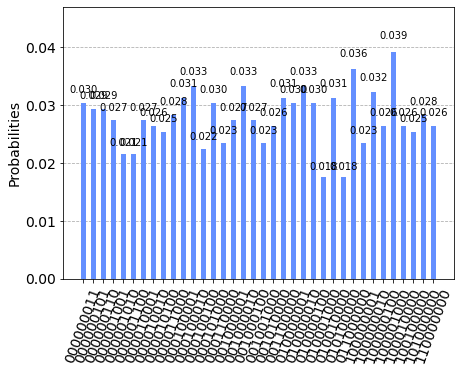

In [16]:
backend = Aer.get_backend('aer_simulator')
backend.shots = 1024

qc = start_state_circ + U99 
qc.measure_all()

qc = transpile(qc, backend)

counts = backend.run(qc, seed_simulator=2701, nshots=4).result().get_counts()
plot_histogram(counts)